In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df=pd.read_csv('/content/filtered_online_retail_data1.csv')

In [ ]:
df['CustomerID'].nunique()

4339

In [ ]:
#dropping unnecessary column
df.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Month,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12,2010-12-01
...,...,...,...,...,...,...,...,...,...,...,...
392727,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20,2011-12,2011-12-09
392728,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60,2011-12,2011-12-09
392729,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011-12,2011-12-09
392730,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011-12,2011-12-09


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392732 entries, 0 to 392731
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    392732 non-null  int64  
 1   StockCode    392732 non-null  object 
 2   Description  392732 non-null  object 
 3   Quantity     392732 non-null  int64  
 4   InvoiceDate  392732 non-null  object 
 5   UnitPrice    392732 non-null  float64
 6   CustomerID   392732 non-null  int64  
 7   Country      392732 non-null  object 
 8   Revenue      392732 non-null  float64
 9   Month        392732 non-null  object 
 10  Date         392732 non-null  object 
dtypes: float64(2), int64(3), object(6)
memory usage: 33.0+ MB


### Time-Based Split

In [ ]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])

date_70q_cutoff=df['InvoiceDate'].quantile(0.7)

In [ ]:
# calibration and holdout data using 70 quantile
calibration= df[df['InvoiceDate']<=date_70q_cutoff]

holdout=df[df['InvoiceDate']>date_70q_cutoff]

### Building RFM Features from Calibration Data

In [ ]:
snapshot_date=calibration['InvoiceDate'].max() + pd.Timedelta(days=1)

In [ ]:
snapshot_date

Timestamp('2011-10-08 13:17:00')

In [ ]:
rfm_cal=calibration.groupby('CustomerID').agg({
    'InvoiceDate':lambda x: (snapshot_date-x.max()).days,
    'InvoiceNo':'nunique',
    'Revenue':'sum'
}).reset_index()

rfm_cal.columns=['CustomerID','Recency','Frequency','Monetary']

### Creating CLV Target from Holdout Data

In [ ]:
clv_target=holdout.groupby('CustomerID')['Revenue'].sum().reset_index()
clv_target.columns=['CustomerID','CLV']

### Merging Features + Target

In [ ]:
clv_df=rfm_cal.merge(clv_target,on='CustomerID',how='inner')

### Feature Engineering

In [ ]:
clv_df['Avg_Order_Value']=clv_df['Monetary'] / clv_df['Frequency']
clv_df['Log_Monetary']=np.log1p(clv_df['Monetary'])
clv_df['Log_Frequency']=np.log1p(clv_df['Frequency'])

## Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X=clv_df[['Recency','Frequency','Monetary','Avg_Order_Value','Log_Monetary','Log_Frequency']]
y=clv_df['CLV']


X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

## Model training and Selection

In [ ]:
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor
)

from xgboost import XGBRegressor

lin_reg = LinearRegression()

rf_reg = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    min_samples_leaf=5,
    random_state=42
)


gb_reg = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.9,
    random_state=42
)

ada_reg = AdaBoostRegressor(
    n_estimators=100,
    learning_rate=0.5,
    random_state=42
)

xgb_reg = XGBRegressor(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.8,
    gamma=0.2,
    min_child_weight=3,
    objective='reg:squarederror',
    random_state=42
)

In [ ]:

regressors = {
    'Linear Reg.' : lin_reg,
    'Random Forest': rf_reg,
    'XGBoost':xgb_reg,
    'Gradient Boosting': gb_reg,
    'AdaBoost':ada_reg,
}


In [ ]:
import math as m

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,f1_score,classification_report,confusion_matrix,recall_score
from sklearn.metrics import mean_absolute_error,root_mean_squared_error,mean_squared_error,r2_score

def train_regressor(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    r2 = r2_score(y_test,y_pred)
    mse = mean_squared_error(y_test,y_pred)
    rmse=m.sqrt(mse)
    mae=mean_absolute_error(y_test,y_pred)

    return [r2,mse,rmse,mae]

In [ ]:
import pandas as pd

results = []

for name, regs in regressors.items():
    r2,mse,rmse,mae= train_regressor(regs, X_train, y_train, X_test, y_test)
    results.append({
        "Model": name,
        "r2": r2,
        "MSE":mse,
        'RMSE':rmse,
        'MAE':mae
    })

df_results = pd.DataFrame(results)

In [ ]:
df_results.sort_values(by='MAE',ascending=True,inplace=True)
df_results

,Model,r2,MSE,RMSE,MAE
3,Gradient Boosting,0.803880,2.305829e+06,1518.495619,547.964049
1,Random Forest,0.562008,5.149576e+06,2269.267693,690.351675
2,XGBoost,0.437107,6.618061e+06,2572.559251,749.151065
4,AdaBoost,0.821355,2.100374e+06,1449.266609,757.004073
0,Linear Reg.,0.815838,2.165239e+06,1471.475101,853.096564


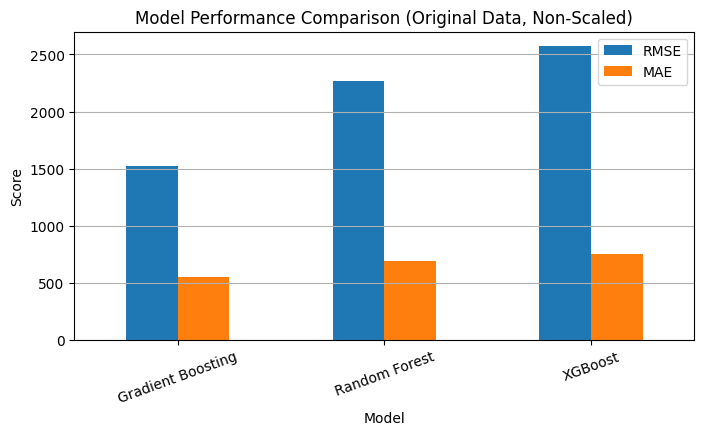

In [ ]:
df_results.head(3).plot(x='Model', y=['RMSE','MAE'], kind='bar', figsize=(8,4), rot=20)
plt.title('Model Performance Comparison (Original Data, Non-Scaled)')
plt.ylabel('Score')
plt.grid(axis='y')
plt.show()

- Gradient Boosting was selected as the final model as it achieved the lowest MAE (547.96), indicating lower average monetary error per customer. The model also showed stable performance on skewed CLV data.
- Tree based models failed due to skewed CLV distribution.

In [ ]:
clv_df['Predicted_CLV'] = gb_reg.predict(X)

## BG/NBD + GAMMA–GAMMA

In [ ]:
!pip install lifetimes

In [ ]:
from lifetimes import BetaGeoFitter,GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data

#### Preparing Data

In [ ]:
summary= summary_data_from_transaction_data(
    df,
    customer_id_col='CustomerID',
    datetime_col='InvoiceDate',
    monetary_value_col='Revenue',
    freq='D'
)

summary

,frequency,recency,T,monetary_value
CustomerID,,,,
12346,0.0,0.0,325.0,0.000000
12347,6.0,365.0,367.0,599.701667
12348,3.0,283.0,358.0,301.480000
12349,0.0,0.0,18.0,0.000000
12350,0.0,0.0,310.0,0.000000
...,...,...,...,...
18280,0.0,0.0,277.0,0.000000
18281,0.0,0.0,180.0,0.000000
18282,1.0,119.0,126.0,77.840000


#### Fit BG/NBD Model

In [ ]:
bgf=BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(
    summary['frequency'],
    summary['recency'],
    summary['T']
)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 49.41, b: 0.00, r: 0.59>

#### Predicting Future Purchases (next 6 months)

In [ ]:
summary['predicted_purchase_6m']=bgf.conditional_expected_number_of_purchases_up_to_time(30,
     summary['frequency'],
    summary['recency'],
    summary['T']
                                                                                         )

In [ ]:
summary_new=summary[summary['frequency']>0]
summary_new=summary_new[summary_new['monetary_value']>0]

#### Predicting Expected Order Value

In [ ]:
ggf=GammaGammaFitter(penalizer_coef=0.1)
ggf.fit(
    summary_new['frequency'],
    summary_new['monetary_value']
)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 1.03, q: 0.18, v: 0.93>

In [ ]:
summary_new['expected_avg_order_value']=ggf.conditional_expected_average_profit(
    summary_new['frequency'],
    summary_new['monetary_value']
)

#### Probabilistic CLV (next 6 Months)

In [ ]:
summary_new['CLV_6m']=summary_new['predicted_purchase_6m']*summary_new['expected_avg_order_value']

In [ ]:
summary_new.sort_values('CLV_6m',ascending=False).head(10)

,frequency,recency,T,monetary_value,predicted_purchase_6m,expected_avg_order_value,CLV_6m
CustomerID,,,,,,,
16446,1.0,205.0,205.0,168469.600000,0.187909,828800.900321,155739.089326
14646,44.0,353.0,354.0,6366.705909,3.316208,6484.138544,21502.752517
12536,1.0,16.0,59.0,8322.120000,0.440962,40945.742831,18055.537039
18102,25.0,367.0,367.0,9349.477200,1.843852,9657.284226,17806.599777
17450,26.0,359.0,367.0,7398.536538,1.915895,7632.457138,14622.988494
14096,16.0,97.0,101.0,4071.434375,3.309564,4284.859684,14181.017464
15749,1.0,97.0,332.0,21535.900000,0.125341,105951.728083,13280.064450
14911,131.0,372.0,373.0,1092.792290,9.345810,1099.486360,10275.590891
12415,15.0,313.0,337.0,7860.210000,1.210634,8301.192462,10049.708276


In [ ]:
summary_new.loc[12347]

,12347
frequency,6.000000
recency,365.000000
T,367.000000
monetary_value,599.701667
predicted_purchase_6m,0.475024
expected_avg_order_value,691.707221
CLV_6m,328.577271


In [ ]:
comparison=clv_df[['CustomerID','Predicted_CLV']].merge(
    summary_new[['CLV_6m']],
    left_on='CustomerID',
    right_index=True,
    how='inner'
)

#### Top Customers by CLV

In [ ]:
comparison.sort_values('CLV_6m',ascending=False).head(10)

,CustomerID,Predicted_CLV,CLV_6m
1250,16446,167882.231300,155739.089326
721,14646,75798.795692,21502.752517
1742,18102,74018.461514,17806.599777
1557,17450,32893.847406,14622.988494
545,14096,50412.014116,14181.017464
812,14911,45891.101580,10275.590891
19,12415,7067.440637,10049.708276
564,14156,13463.150857,8622.409368
1570,17511,22078.451364,6673.939826
1127,16029,12558.062299,5683.946735


#### Correlation Check (Between Gradient Boosting and BG/NBD and Gamma Gamma approach)

In [ ]:
comparison[['Predicted_CLV',	'CLV_6m']].corr()

,Predicted_CLV,CLV_6m
Predicted_CLV,1.00000,0.89327
CLV_6m,0.89327,1.00000


- High Correlation Between Predicted_CLV and CLV_6m (0.89)

#### Customers in each segments

In [ ]:
#Using quantiles
summary_new['CLV_segments']=pd.qcut(
    summary_new['CLV_6m'],
    q=[0,0.5,0.8,1.0],
    labels=['Low Value','Medium Value','High Value']
)

In [ ]:
summary_new['CLV_segments'].value_counts(normalize=True)

,proportion
CLV_segments,
Low Value,0.5
Medium Value,0.3
High Value,0.2


In [ ]:
summary_new['CLV_segments'].value_counts(normalize=True)*100

,proportion
CLV_segments,
Low Value,50.0
Medium Value,30.0
High Value,20.0


<Axes: ylabel='count'>

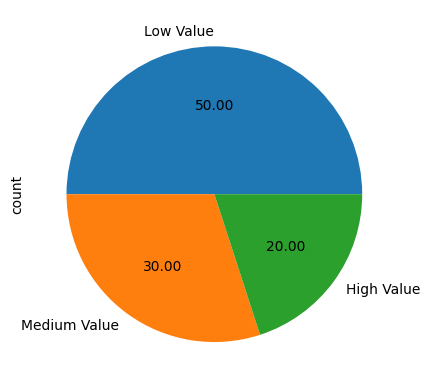

In [ ]:
summary_new['CLV_segments'].value_counts().plot(kind='pie',autopct='%0.2f')

- There are 50% low value customers and 30% Medium value and 20% High value

#### Revenue contribution by segment

In [ ]:
summary_new.groupby('CLV_segments')['CLV_6m'].sum()

,CLV_6m
CLV_segments,
Low Value,165158.490804
Medium Value,252489.250297
High Value,807628.711454


<Axes: ylabel='CLV_6m'>

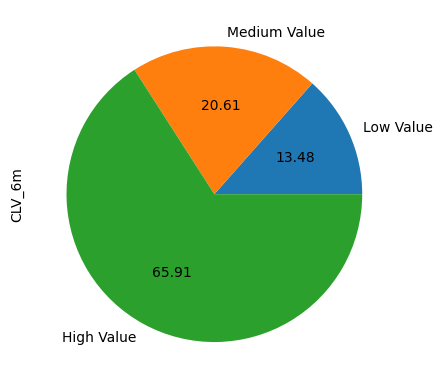

In [ ]:
(summary_new.groupby('CLV_segments')['CLV_6m'].sum()).plot(kind='pie',autopct='%0.2f')

- A small group of High Value customers contributes a large share (~66%) of predicted 6 month revenue
- Half of whole customer base will contribute less than 20% of revenue for next 6months
- Medium value customers with (~30%) contribute ~20% CLV and represent strong upsell potential.

#### Top 10 customers by CLV

In [ ]:
summary_new.sort_values(by='CLV_6m',ascending=False).head(10)

,frequency,recency,T,monetary_value,predicted_purchase_6m,expected_avg_order_value,CLV_6m,CLV_segments
CustomerID,,,,,,,,
16446,1.0,205.0,205.0,168469.600000,0.187909,828800.900321,155739.089326,High Value
14646,44.0,353.0,354.0,6366.705909,3.316208,6484.138544,21502.752517,High Value
12536,1.0,16.0,59.0,8322.120000,0.440962,40945.742831,18055.537039,High Value
18102,25.0,367.0,367.0,9349.477200,1.843852,9657.284226,17806.599777,High Value
17450,26.0,359.0,367.0,7398.536538,1.915895,7632.457138,14622.988494,High Value
14096,16.0,97.0,101.0,4071.434375,3.309564,4284.859684,14181.017464,High Value
15749,1.0,97.0,332.0,21535.900000,0.125341,105951.728083,13280.064450,High Value
14911,131.0,372.0,373.0,1092.792290,9.345810,1099.486360,10275.590891,High Value
12415,15.0,313.0,337.0,7860.210000,1.210634,8301.192462,10049.708276,High Value


In [ ]:
summary_new.to_excel('customer_clv.xlsx')

In [ ]:
summary_new.shape

(2790, 8)